<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#First-step:-estimates-the-necessary-quadrupole-variation-to-perform-emittance-crossing" data-toc-modified-id="First-step:-estimates-the-necessary-quadrupole-variation-to-perform-emittance-crossing-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>First step: estimates the necessary quadrupole variation to perform emittance crossing</a></span></li><li><span><a href="#Building-auxiliary-functions" data-toc-modified-id="Building-auxiliary-functions-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Building auxiliary functions</a></span></li><li><span><a href="#Emittance-exchange-simulation-(open-code)" data-toc-modified-id="Emittance-exchange-simulation-(open-code)-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Emittance exchange simulation (open code)</a></span></li><li><span><a href="#Second-step:-Making-the-heat-map-of-emittance-exchange-quality" data-toc-modified-id="Second-step:-Making-the-heat-map-of-emittance-exchange-quality-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Second step: Making the heat map of emittance exchange quality</a></span></li></ul></div>

In [136]:
import numpy as np
import matplotlib.pyplot as plt
from apsuite.emittance_exchange.bo_tune_measure import tune_measure as tm
import pymodels as pm
import pyaccel as pa
%config Completer.use_jedi = False
import pandas as pd
import seaborn as sns
from numpy.fft import rfft, rfftfreq, irfft
from scipy.signal import hilbert
from IPython.display import display, Math, Markdown

# First step: estimates the necessary quadrupole variation to perform emittance crossing

Our objective is find the quadrupoles strength that makes $\Delta = \hat{\nu}_x - \hat{\nu}_y = 0$, in the machine without coupling. When we set some coupling, this configuration leads to emmitance crossing. 

The relation between the a variation in quadrupoles and a variation in tunes are:

\begin{equation}
d K \approx \pm \frac{4 \pi \, d \nu}{\sum \beta_i l_i}
\end{equation}

where $\beta_i$ and $l_i$ refers to the average $\beta$-function over and
the length of quadrupole i, respectively. The sign depends
on the plane (positive for the horizontal plane and negative
for the vertical plane), and, similarly, the $\beta$ i is either the
horizontal or vertical $\beta$-function.

*Notation remark*: In this notebook i am using $d f$ notation as a reference to a finite variation of f, like the usual $\Delta f$, that was discarded because the $\Delta$ is already used to represent tune difference. Do not think $d f$ as infinitesimal variation.

* Creating the machine

In [3]:
obj = tm.BPMeasure()
obj.create_booster(rad=False, QF_KL=None, KsL=None)
tune1, tune2 = obj._eqparams.tune1, obj._eqparams.tune2
delta = tune1%1 - tune2%1

display(Math(r"\nu_x = {:.2f}, \\ \nu_y = {:.2f},\\ \Delta = {:.2f}.".format(tune1, tune2, delta)))

<IPython.core.display.Math object>

Lets suppose that the emittance exchange will be occur in a **static case**, where from cycle to cycle the tune in one plane is usually varied, keeping the other fixed. Both tunes remain constant during each cycle.

So, lets consider that $d \nu_y \approx 0$ when varying $\nu_x$ in order to get $\Delta = 0$.

Consider that $\Delta_0 + d\Delta =0$, where $\Delta_0$ is the initial tune separation and $d \Delta$ is the variation of $\Delta$ during the emittance exchange process. Therefore:

\begin{equation}
d \hat{Q}_x =  - \Delta_0
\end{equation}

Therefore, the needed variation in quadrupoles is
\begin{equation}
d K_x = - \frac{4 \pi \Delta_0}{\sum \beta_i l_i}
\end{equation}

But, for some reason that I couldn't explain, the above formula only returns the right values if we divide the right side by 2.

\begin{equation}
d K_x = - \frac{2 \pi \Delta_0}{\sum \beta_i l_i} 
\end{equation}

In [4]:
qf_idx = obj._famdata['QF']['index'].copy()
spos = obj._et.spos
betax = obj._et.beta1

In [5]:
# Assuming that the QF quadrupoles have equally lengths:
l = obj._bo[qf_idx[0]].length 
betas = np.zeros(len(qf_idx))

for i,idx in enumerate(qf_idx):
    idx1, idx2 = idx
    beta_values = betax[[idx1, idx2, idx2+1]]
    betas[i] = np.mean(beta_values)
sum_beta_l = np.sum(betas*l)

In [6]:
deltaK = -2*np.pi*delta/(sum_beta_l)
deltaKL = deltaK * l
print("d K = {} m^-2 \n d KL = {} m^-1 ".format(deltaK, deltaKL))

d K = 0.0025996062269295016 m^-2 
 d KL = 0.0005927102197399264 m^-1 


* Lets test this value with a new machine and check the tune values.

In [7]:
obj2 = tm.BPMeasure()
obj2.create_booster()
KL_default = obj2._bo[qf_idx[0][0]].KL

KL_crossing = KL_default + deltaKL - 0.00011 # The last term is an euristic correction
K_crossing = KL_crossing/l
obj2.create_booster(rad=False, QF_KL=KL_crossing)
tunex, tuney = obj2._eqparams.tune1, obj2._eqparams.tune2

display(Math(r" K_(QF) = {:.5f} \\ KL_(QF) = {:.5f} \\ \nu_x = {:.5f} \\ \nu_y = {:.5f}".format(K_crossing, KL_crossing, tunex%1 , tuney%1)))

<IPython.core.display.Math object>

# Building auxiliary functions


Defining the function witch computes emittance exchange quality 

In [8]:
def calc_R(emit1_0, emit2_0,emit1):
    R = 1 - (emit1 - emit2_0)/(emit1_0 - emit2_0)
    return R

In [9]:
def C_to_KsL(acc, C):
    fam_data = pm.bo.get_family_data(acc)
    qs_idx = fam_data['QS']['index']
    ed_tang, *_ = pa.optics.calc_edwards_teng(accelerator=acc)
    beta1 = ed_tang.beta1[qs_idx[0]]
    beta2 = ed_tang.beta2[qs_idx[0]]
    KsL = -2 * np.pi * C / np.sqrt(beta1 * beta2)
    
    return KsL[0]

Creating a function to compute $\sum \beta_i l_i$

In [10]:
def compute_sum_beta_l(acc):    
    ed_teng, _ = pa.optics.calc_edwards_teng(bo)
    famdata = pm.bo.get_family_data(acc)
    qf_idx = famdata['QF']['index'].copy()
    
    betax = ed_teng.beta1
    l = bo[qf_idx[0]].length 
    betas = np.zeros(len(qf_idx))

    for i,idx in enumerate(qf_idx):
        idx1, idx2 = idx
        beta_values = betax[[idx1, idx2, idx2+1]]
        betas[i] = np.mean(beta_values)
    sum_beta_l = np.sum(betas*l)
    
    return sum_beta_l, l

Creating a function to help us to initialize the machine with $\Delta = - A|C|$, with A being a real number. 

In [11]:
def set_tune_sep(acc, delta_f):
    "Sets delta to delta_f"
       
    bo = acc[:]
    famdata = pm.bo.get_family_data(bo)
    qf_idx = np.array(famdata['QF']['index']).flatten()
    eqparams = pa.optics.EqParamsFromBeamEnvelope(bo)
    ed_teng, _ = pa.optics.calc_edwards_teng(bo)
    C, _ = pa.optics.estimate_coupling_parameters(ed_teng)
    
    tune1, tune2 = eqparams.tune1, eqparams.tune2
    delta_c = tune1 - tune2
    delta = np.sign(delta_c) * np.sqrt(delta_c**2 - C**2)
    
    sum_beta_l, l = compute_sum_beta_l(bo)
    dv_x = delta_f - delta
    deltaK_x = 2*np.pi*dv_x/(sum_beta_l)
    deltaKL_x = deltaK_x * l
    
    KL_x  = bo[qf_idx[0]].KL
    for qf in qf_idx:
        bo[qf].KL = KL_x + deltaKL_x
    
    eqparams = pa.optics.EqParamsFromBeamEnvelope(bo)
    tune1, tune2 = eqparams.tune1, eqparams.tune2
    delta_c = tune1 - tune2
    delta = np.sign(delta_c) * np.sqrt(delta_c**2 - C**2)
    
    #display(Math(r"\nu_1 = {:.3f} \\ \nu_2 = {:.3f}".format(tune1%1 , tune2%1)))
    #print(rf"$\Delta$ setted to {delta}")
    return bo, delta

Searching for values of coupling that avoid integer resonances 

In [67]:
KsL_list = np.linspace(0.001, 0.03, num=10)
deltas = np.zeros(KsL_list.size)
tune1 = np.zeros(KsL_list.size)
tune2 = tune1.copy()
A = 6
C_list = deltas.copy()
precision = C_list.copy()
for i, ksl in enumerate(KsL_list):
    objtest2 = tm.BPMeasure()
    objtest2.create_booster(KsL = ksl)
    C = objtest2._coupling_coef
    C_list[i] = C
    objtest2, deltas[i] = set_tune_sep(objtest2, -A*C)
    tune1[i] = objtest2.eqparams.tune1
    tune2[i] = objtest2.eqparams.tune2
    deltas[i] /= C

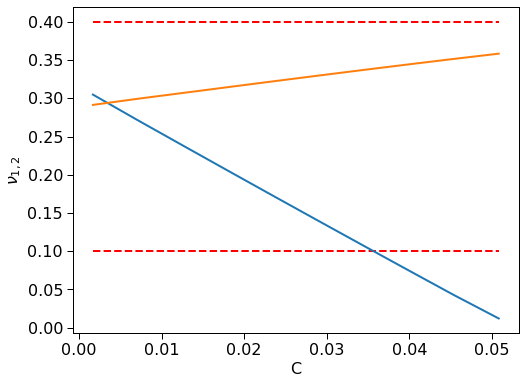

In [68]:
plt.plot(C_list, tune1)
plt.plot(C_list, tune2)
plt.hlines(0.1, np.min(C_list), np.max(C_list), 'r', linestyle='--')
plt.hlines(0.4,  np.min(C_list), np.max(C_list), 'r', linestyle='--')
plt.xlabel('C')
plt.ylabel(r'$\nu_{1,2}$')
plt.show()

Lets limit our coupling coefficient to $ 0.01 < C < 0.03 $

In [71]:
C_min = 0.01
C_max = 0.03
KsL_min = C_to_KsL(objtest2._bo, C_min)
KsL_max = C_to_KsL(objtest2._bo, C_max)
print(' KsL minimum: {:.4f} \n KsL maximum: {:.4f}'.format(KsL_min, KsL_max))

 KsL minimum: -0.0051 
 KsL maximum: -0.0154


# Emittance exchange simulation (open code)

Creating the machine


In [12]:
bo = pm.bo.create_accelerator(energy=3e9)
bo.vchamber_on = True
bo.cavity_on = True
bo.radiation_on = False

# Geting information 
famdata = pm.bo.get_family_data(bo)

# Setting coupling
KsL = -0.015
qs_idx = famdata['QS']['index']
bo[qs_idx[0][0]].KsL = KsL

#Getting default quadrupoles strength
qf_idx = famdata['QF']['index']
KL_default = bo[qf_idx[0][0]].KL
#KL_crossing = 0.18911

ed_teng, _ = pa.optics.calc_edwards_teng(bo)
C, _ = pa.optics.estimate_coupling_parameters(ed_teng)
print(f'Coupling coefficient: {C}')

Coupling coefficient: 0.02533067517096


Creating the bunch

In [13]:
# Creating the bunch
eqparams = pa.optics.EqParamsFromBeamEnvelope(bo)
emit1, emit2 = eqparams.emit1, np.abs(eqparams.emit2)
sigmae, sigmal = eqparams.espread0, eqparams.bunlen
# #redistributing emittances
# emit = emit1 + emit2
# emit1, emit2 =  0.8*emit, 0.2*emit

bunch = pa.tracking.generate_bunch(n_part=1000, emit1=emit1,
                                                  emit2=emit2,
                                                  optics=ed_teng[0],
                                                  sigmae=sigmae, sigmas=sigmal)
co = pa.tracking.find_orbit6(accelerator=bo, indices=[0])
bunch += co - np.mean(bunch, axis=1)[:, None]

Tracking the emittance exchange

In [14]:
bo, delta = set_tune_sep(bo, -6*C)
print("Initial delta = {:.3f} [C]".format(delta/C))

KL_default = bo[qf_idx[0][0]].KL

N = 1000 # Turns until the exchange
dKL = KL_crossing - KL_default
KL_list = np.linspace(KL_default, KL_default + 2*dKL, 2*N)

emitx_list = np.zeros(KL_list.shape)
emity_list = emitx_list.copy()
tune1_list, tune2_list = emitx_list.copy(), emitx_list.copy()
energy_info = np.zeros([2, KL_list.size])

bunch0 = bunch

# The first N steps are to perfom emittance crossing and the last 
# N are to complete the exchange.
for i, KL in enumerate(KL_list):
    
    # Changing quadrupole forces
    qf_idx = np.array(famdata['QF']['index']).flatten()
    for qf in qf_idx:
        bo[qf].KL = KL
    
    # Making the linear map
    m66 = pa.tracking.find_m66(bo)
    bunch0 = np.dot(m66, bunch0)
    
    # Computing the RMS emittance
    twi, *_ = pa.optics.calc_twiss(bo)
    etax, etapx = twi.etax[0], twi.etapx[0]
    etay, etapy = twi.etay[0], twi.etapy[0]
    disp = np.array([[etax], [etapx], [etay], [etapy], [0], [0]])
    bunch_nodisp = bunch0 - bunch0[4]*disp - np.mean(bunch0, axis=1)[:, None]
    emitx_list[i] = np.sqrt(np.linalg.det(np.cov(bunch_nodisp[:2,:])))
    emity_list[i] = np.sqrt(np.linalg.det(np.cov(bunch_nodisp[2:4,:])))

    # Computing Tunes
    eqparams = pa.optics.EqParamsFromBeamEnvelope(bo)
    tune1_list[i], tune2_list[i] = eqparams.tune1, eqparams.tune2
    
    # Saving the beam energy through the exchange
    energy_info[0,i] = np.mean(bunch0[4])
    energy_info[1,i] = np.var(bunch0[4])
    
    # Printing progress
    if i % 100 == 0:
        print(f"step {i}", end='\t')
    if i % 500 == 0:
        print('')

Initial delta = -6.363 [C]
step 0	
step 100	step 200	step 300	step 400	step 500	
step 600	step 700	step 800	step 900	step 1000	
step 1100	step 1200	step 1300	step 1400	step 1500	
step 1600	step 1700	step 1800	step 1900	

In [15]:
T_r = 1.657 * 1e-3 #  Revolution period [ms]
S = np.abs(tune1_list[0] - tune2_list[0])/(N * T_r*C**2)
print(S)

153.46322489145916


Plotting the results

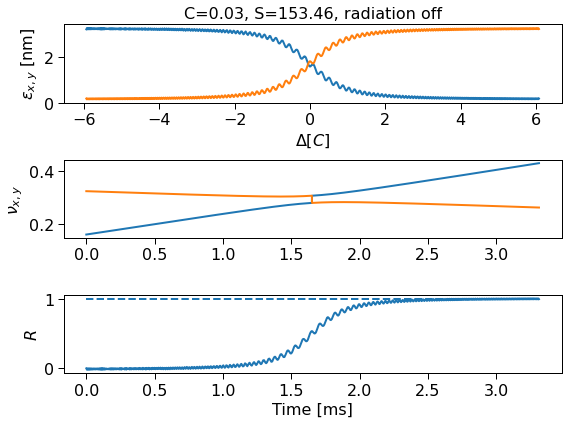

In [150]:
plt.style.use(['notebook', 'no-latex'])
deltae = tune1_list - tune2_list
C = np.min(np.abs(deltae)) # True coupling coefficent
delta = np.sign(deltae)*np.sqrt(deltae**2 - C**2)
R = calc_R(emitx_list[0], emity_list[0], emitx_list)

fig,ax = plt.subplots(3,1, sharex=False)

Ns = np.arange(len(delta))
t = Ns * T_r

ax[0].plot(delta/C, emitx_list*1e9)
ax[0].plot(delta/C, emity_list*1e9)
ax[0].set_ylabel(r"$\epsilon_{x,y}$ [nm]")
ax[0].set_xlabel(r'$\Delta [C]$')
ax[0].set_title('C={:.2f}, S={:.2f}, radiation off'.format(C, S))

ax[1].plot(t, tune1_list)
ax[1].plot(t, tune2_list)
ax[1].set_ylabel(r"$\nu_{x,y}$")

ax[2].plot(t, R)
ax[2].set_ylabel('$R$')
ax[2].set_xlabel("Time [ms]")
ax[2].hlines(1, np.min(t), np.max(t), linestyle='--')

plt.tight_layout()

Energy/emittance oscillations

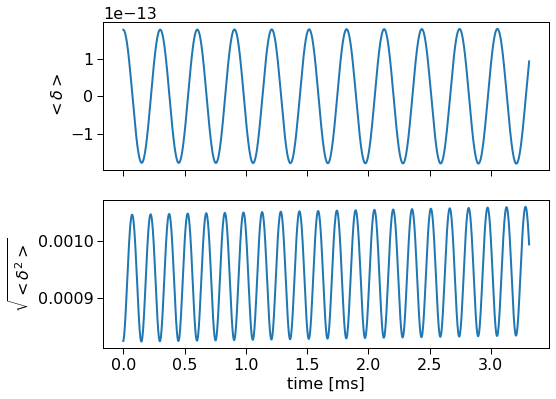

In [49]:
#plt.plot(ed_teng.spos, ed_teng.beta1)
fig,ax = plt.subplots(2,1, sharex=True)

ax[0].plot(t, energy_info[0])
ax[0].set_ylabel("$< \delta >$")
ax[1].plot(t, np.sqrt(energy_info[1]))
ax[1].set_ylabel(r"$\sqrt{<\delta^2>}$")

ax[1].set_xlabel("time [ms]")
plt.show()

Emittance oscillations analysis 

In [189]:
fftx = np.abs(rfft(emitx_list ))
ffty = np.abs(rfft(emity_list ))
fftx /= (fftx.max() - fftx.min())
mean_energy_spec = np.abs(rfft(energy_info[0] ))
mean_energy_spec /= mean_energy_spec.max() - mean_energy_spec.min()
std_energy_spec = np.abs(rfft(energy_info[1] ))
std_energy_spec /= std_energy_spec.max() - std_energy_spec.min()
freqs = rfftfreq(window.size, t[-1]/(2*N))

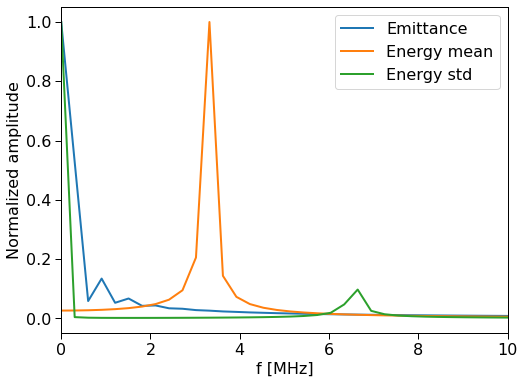

In [190]:
start = 0
plt.plot(freqs[start:], fftx[start:], label="Emittance")
plt.plot(freqs[start:], mean_energy_spec[start:], label="Energy mean" )
plt.plot(freqs[start:], std_energy_spec[start:], label="Energy std" )

#plt.plot(freqs[15:], ffty[15:])
plt.xlabel('f [MHz]')
plt.ylabel("Normalized amplitude")
plt.legend()
plt.xlim([0,10])
plt.show()

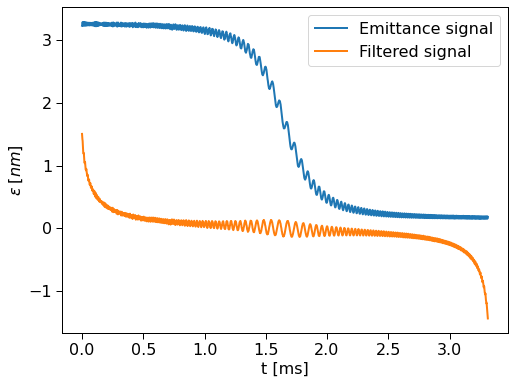

In [223]:
fftx = rfft(emitx_list)[6:]
ifftx = irfft(fftx, n = 2*N)
t2=t
plt.plot(t, emitx_list*1e9, label='Emittance signal')
plt.plot(t2, ifftx*1e9, label='Filtered signal' )
plt.ylabel("$\epsilon \; [nm]$")
plt.xlabel('t [ms]')
plt.legend()

Finding the instantaneous frequency

<function matplotlib.pyplot.tight_layout(*, pad=1.08, h_pad=None, w_pad=None, rect=None)>

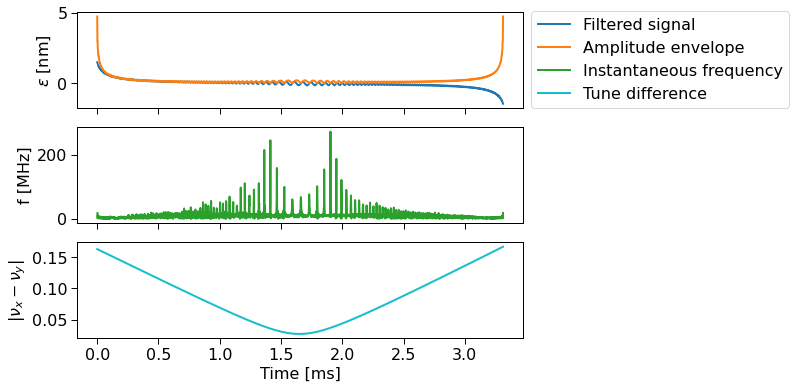

In [231]:
fs = 2*N/t[-1]
analytic_signal = hilbert(ifftx)
instantaneous_phase = np.unwrap(np.angle(analytic_signal))
instantaneous_frequency = (np.diff(instantaneous_phase)/(2.0*np.pi) * fs)
amplitude_envelope = np.abs(analytic_signal)
fig, ax = plt.subplots(3,1, sharex=True)
ax[0].plot(t2, ifftx*1e9, label="Filtered signal")
ax[0].plot(t2, amplitude_envelope*1e9,  label="Amplitude envelope")
ax[0].set_ylabel("$\epsilon$ [nm]")
ax[1].plot(t2[1:], np.abs(instantaneous_frequency),c='tab:green', label="Instantaneous frequency")
ax[1].set_ylabel('f [MHz]')

ax[2].plot(t, abs(deltae),  c = 'tab:cyan', label='Tune difference')
ax[2].set_xlabel('Time [ms]')
ax[2].set_ylabel(r"$|\nu_x - \nu_y|$")
fig.legend(bbox_to_anchor=(0.9,0.9),loc="upper left")
plt.tight_layout

# Second step: Making the heat map of emittance exchange quality 

The rate of change of $\Delta$ can be defined in following way:

$\dot{\Delta} = d\Delta/N$

where $N$ is the number of revolutions that it takes to perform the **emittance crossing**. The simulation finishes after N revolutions after the crossing.

In [65]:
KsL_list = np.linspace(0, -0.02, num=10)
N_list = np.logspace(1, 3.5, num=10)
coupling_list = KsL_list.copy()
R_matrix = np.zeros([N_list.size, coupling_list.size])

In [66]:
for N_idx, N in enumerate(N_list):
    N = int(N)
    for C_idx, KsL in enumerate(KsL_list): 
        obj = tm.BPMeasure()
        obj.create_booster(rad=False, KsL=KsL)
        C = obj._coupling_coef
        coupling_list[C_idx] = C
        
        obj.create_initial_bunch(n_part=1000)
        
        step = (KL_crossing - KL_default)/N
        
        KL_list = np.arange(KL_default, 2*KL_crossing, step)
        
        emit1_list = np.zeros(2*N)
        emit2_list = emit1_list.copy()
        tune1_list, tune2_list = emit1_list.copy(), emit1_list.copy()
        bunch0 = obj._bunch
        
        #  Tracking with ring pass for 2N steps after teorical crossing.
        # The first N steps are to perfom emittance crossing and the last 
        # N are to complete the exchange.
        for i in range(2*N):
            obj.change_QF(KL=KL_list[i])
            bunch0, *_ = pa.tracking.ring_pass(accelerator=obj._bo, particles=bunch0, nr_turns=1, parallel=True)
            
            # Computing the RMS emittance
            emit1_list[i] = np.sqrt(np.linalg.det(np.cov(bunch0[:2,:])))
            emit2_list[i] = np.sqrt(np.linalg.det(np.cov(bunch0[2:4,:])))
            
            # Computing Tunes
            eqparams = pa.optics.EqParamsFromBeamEnvelope(obj._bo)
            tune1_list[i], tune2_list[i] = eqparams.tune1, eqparams.tune2
            
        R = calc_R(emit1=emit1_list[-1], emit1_0=emit1_list[0],
                  emit2_0=emit2_list[0])
        R_matrix[C_idx, N_idx] = R

In [69]:
np.save("R_matrix", R_matrix)

Text(33.0, 0.5, 'Coupling')

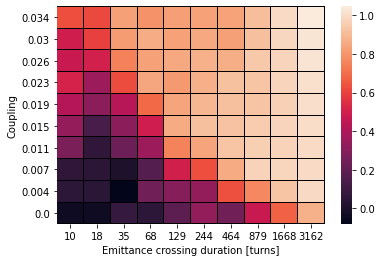

In [79]:
R_df = pd.DataFrame(R_matrix, index = np.round(coupling_list,3), columns=N_list.astype('int'))
R_df = R_df.reindex(index=R_df.index[::-1])
sns.heatmap(R_df, linewidths=.05, linecolor='k')
plt.xlabel("Emittance crossing duration [turns]")
plt.ylabel("Coupling")